# 0.0. IMPORTAÇÕES

In [1]:
import datetime
import inflection
import math
import numpy as np
import pandas as pd
import pickle
import random
import requests
import seaborn as sns
import warnings
import xgboost as xgb

from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy                 import stats as ss
from tabulate              import tabulate

warnings.filterwarnings('ignore')

## 0.1. Funções Auxiliares

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nNúmero KFold: {}'.format(k))
            
        # data inicial e final para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtragem dos dados
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]
        
        # dataset de treinamento
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # dataset de validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # modelo
        m = model.fit(xtraining, ytraining)
        
        # predição
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # desempenho para cada iteração kfold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Nome do Modelo': model_name,
                         'MAE CV': round(np.mean(mae_list), 2).astype(str) + '+/-' + round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': round(np.mean(mape_list), 2).astype(str) + '+/-' + round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': round(np.mean(rmse_list), 2).astype(str) + '+/-' + round(np.std(rmse_list), 2).astype(str)
                        }, index=[0])


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Nome do modelo': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

## 0.2. Carregando os Dados

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# mesclando os dataframe
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

pd.set_option('display.max_columns', None)

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Renomeando as colunas

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# renomeando as colunas
df1.columns = cols_new

## 1.2. Dimensão dos dados

In [6]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3. Tipo de dados

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checando os NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preenchendo os NA

In [9]:
# competition_distance
# Adotaremos que nos casos com NA é porque não há competidores próximos. Por isso preencheremos
# as linhas NA com um valor bem mais alto do que a maior distância do Database.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Adotaremos a data da compra como mês de abertura da loja.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                                          else x['competition_open_since_month'], axis=1)

# competition_open_since_year
# Adotaremos a data da compra como ano de abertura da loja.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                        else x['competition_open_since_year'], axis=1)

# promo2_since_week
# Adotaremos a data da compra como semana do início da promoção na loja.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                              else x['promo2_since_week'], axis=1)

# promo2_since_year
# Adotaremos a data da compra como ano do início da promoção na loja.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                              else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2:'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Adotaremos que nas linhas com NA não há promoção, por isso adotou-se 0.
df1['promo_interval'].fillna(0, inplace=True)

# Criamos a coluna 'month_map' para receber o mês da compra.
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Criamos a coluna 'is_promo' para identificar se a compra foi durante os meses de promoção (1) ou não (0)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0
    else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6. Alterando os tipos de dados

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Estatística Descritiva

In [11]:
atributos_num = df1.select_dtypes(include=['int64', 'float64'])
atributos_cat = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Atributos numéricos

In [12]:
# tendência central - mean e median
tc1 = pd.DataFrame(atributos_num.apply(np.mean)).T
tc2 = pd.DataFrame(atributos_num.apply(np.median)).T

# dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(atributos_num.apply(np.std)).T
d2 = pd.DataFrame(atributos_num.apply(min)).T
d3 = pd.DataFrame(atributos_num.apply(max)).T
d4 = pd.DataFrame(atributos_num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(atributos_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(atributos_num.apply(lambda x: x.kurtosis())).T

# concatenando as métricas
m = pd.concat([d2, d3, d4, tc1, tc2, d1, d5, d6]).T.reset_index()
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Atributos Categóricos

In [13]:
atributos_cat.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

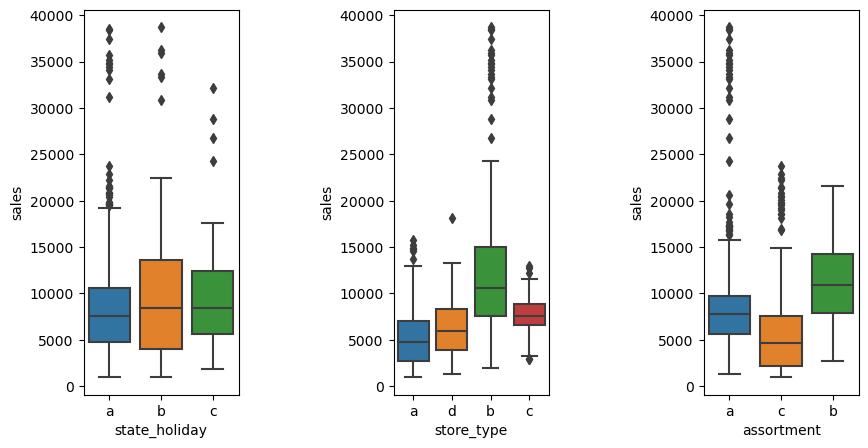

In [14]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
plt.subplots_adjust(wspace=1)

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axs[0]);
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axs[1]);
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axs[2]);

# 2.0. PASSO 02 - FEATURE ENGINEERING

## 2.1. Mapa Mental de Hipóteses

!['Mapa mental de hipóteses'](img/MindMapHypothesis.png)

## 2.2. Criação das Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com compeditores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto deveriam vender mais.

**3.** Lojas que têm preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com compeditores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

_Algumas hipóteses criadas precisarão de um tratamento maior dos dados. Com criação de novas features, etc.<br>
Por isso iremos priorizar as hipóteses que conseguimos fazer mais rápido._

## 2.4. Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day 
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
                                               year=x['competition_open_since_year'],
                                               month=x['competition_open_since_month'], day=1), axis=1)

# competition time month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(
                                lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
    
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') -
                                                        datetime.timedelta(days=7))

# promo time week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                            'easter_holiday' if x == 'b' else
                                                            'christimas'     if x == 'c' else 'regular_day')

# 3.0. PASSO 03 - FILTRAGEM DAS VARIÁVEIS

## 3.1. Filtragem de Variáveis

In [17]:
df3 = df2.copy()

### 3.1.1. Filtragem das Linhas

In [18]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.1.2. Filtragem de Colunas

In [19]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [20]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

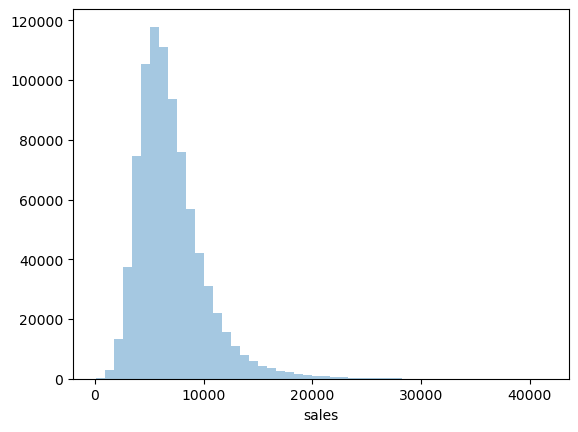

In [21]:
sns.distplot(df4['sales'], kde=False);

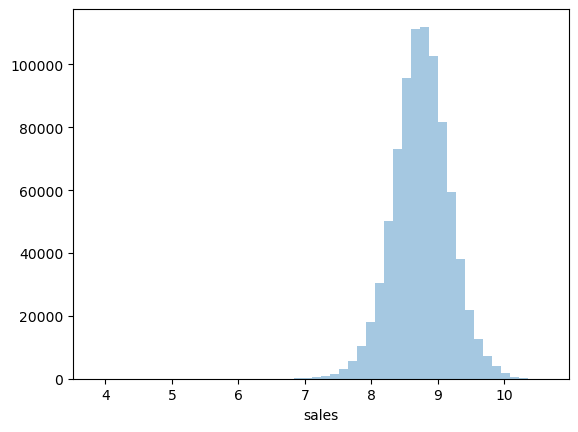

In [22]:
# Normalizando a distribuição para melhorar a performance do algoritmo de ML
sns.distplot(np.log1p(df4['sales']), kde=False);

### 4.1.2. Variável Numérica

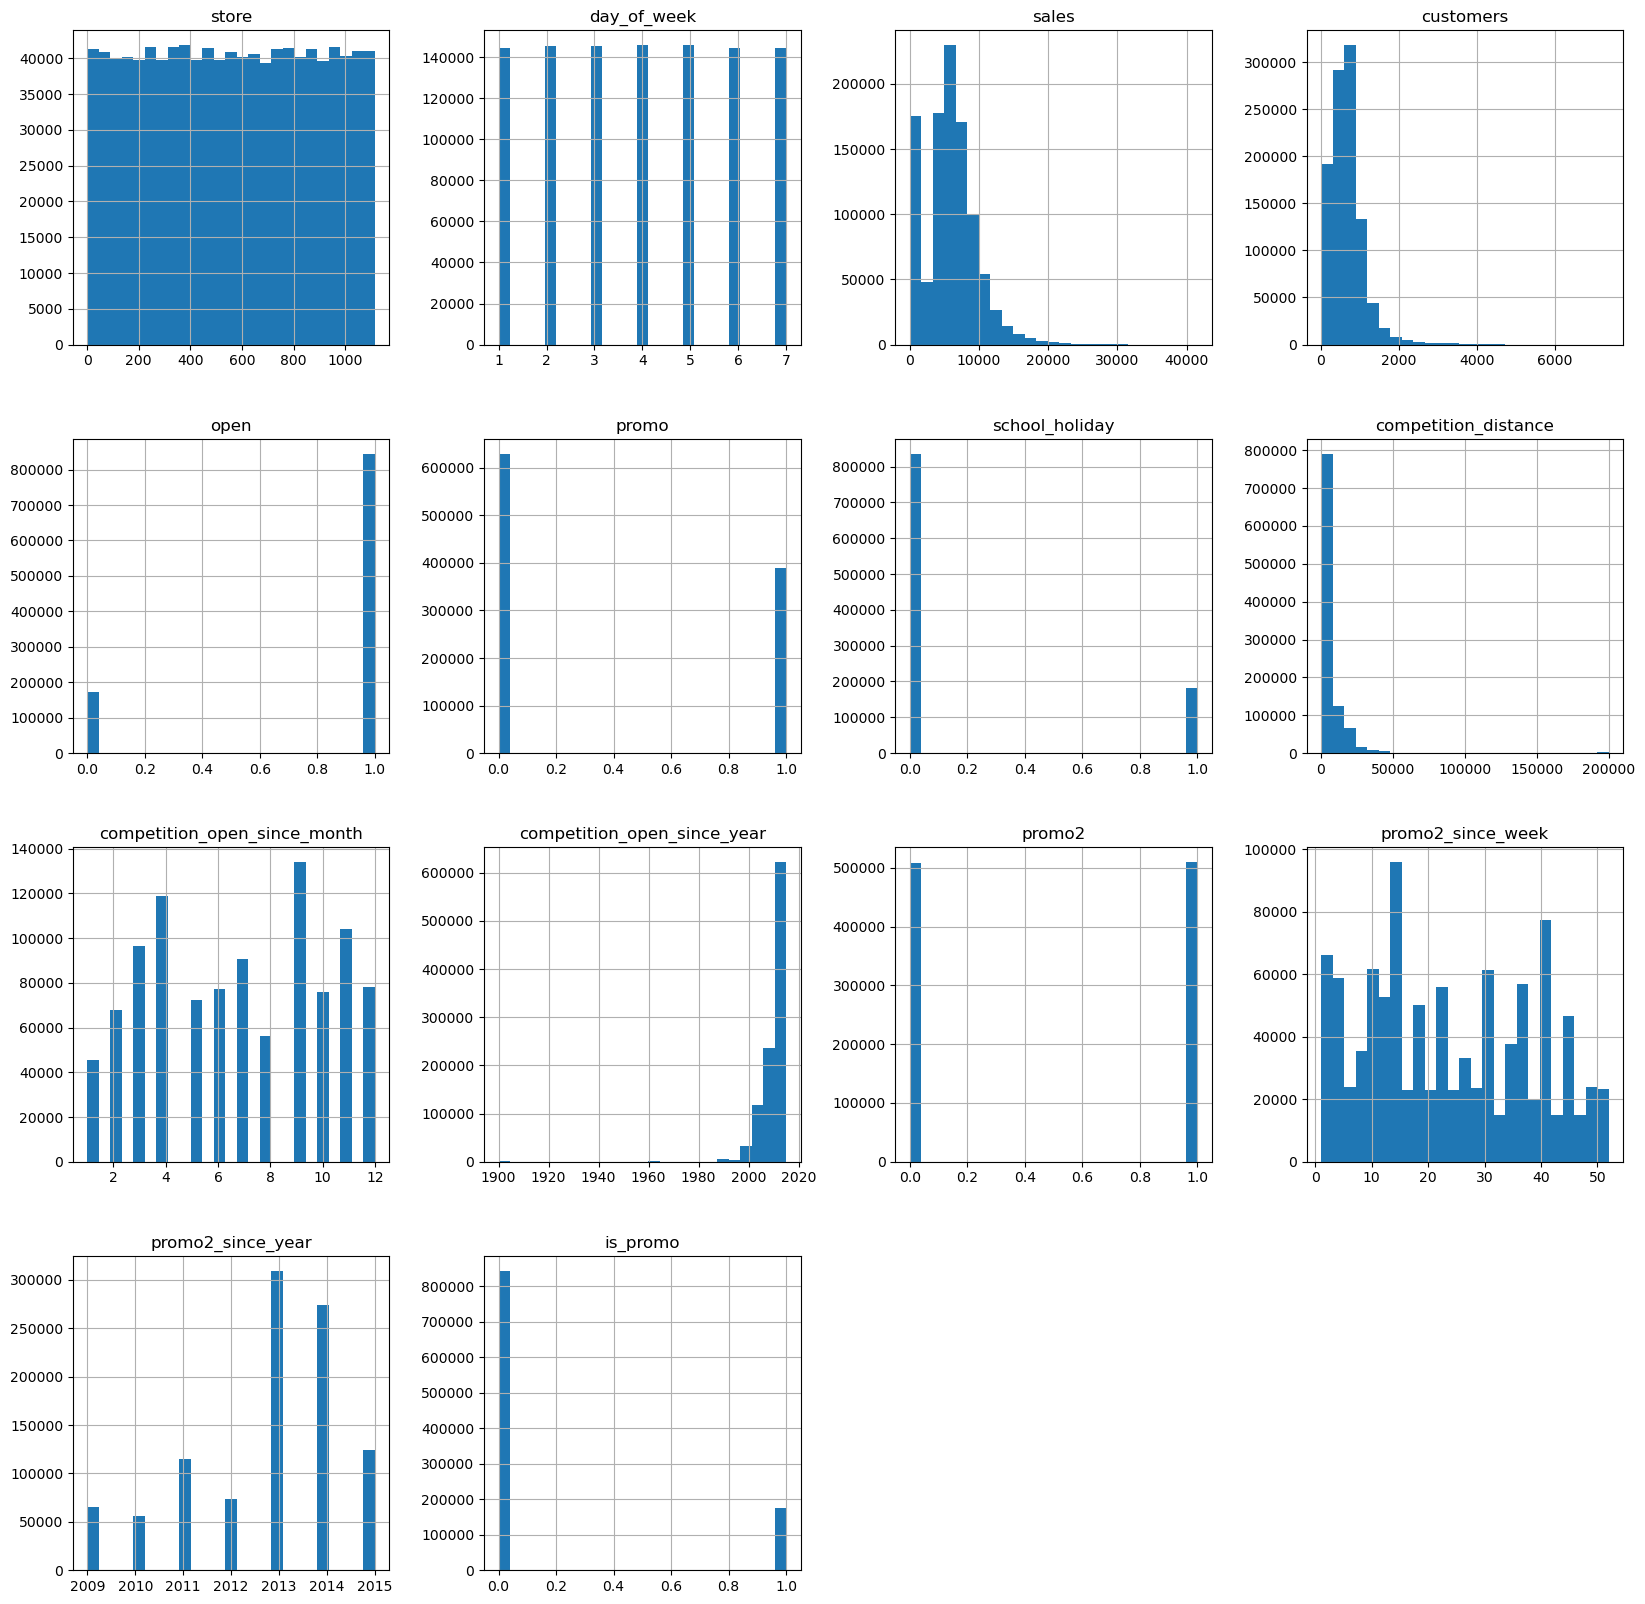

In [23]:
fig = plt.figure(figsize=(20, 20))

atributos_num.hist(bins=25, ax=fig.gca());

### 4.1.3. Variável Categórica

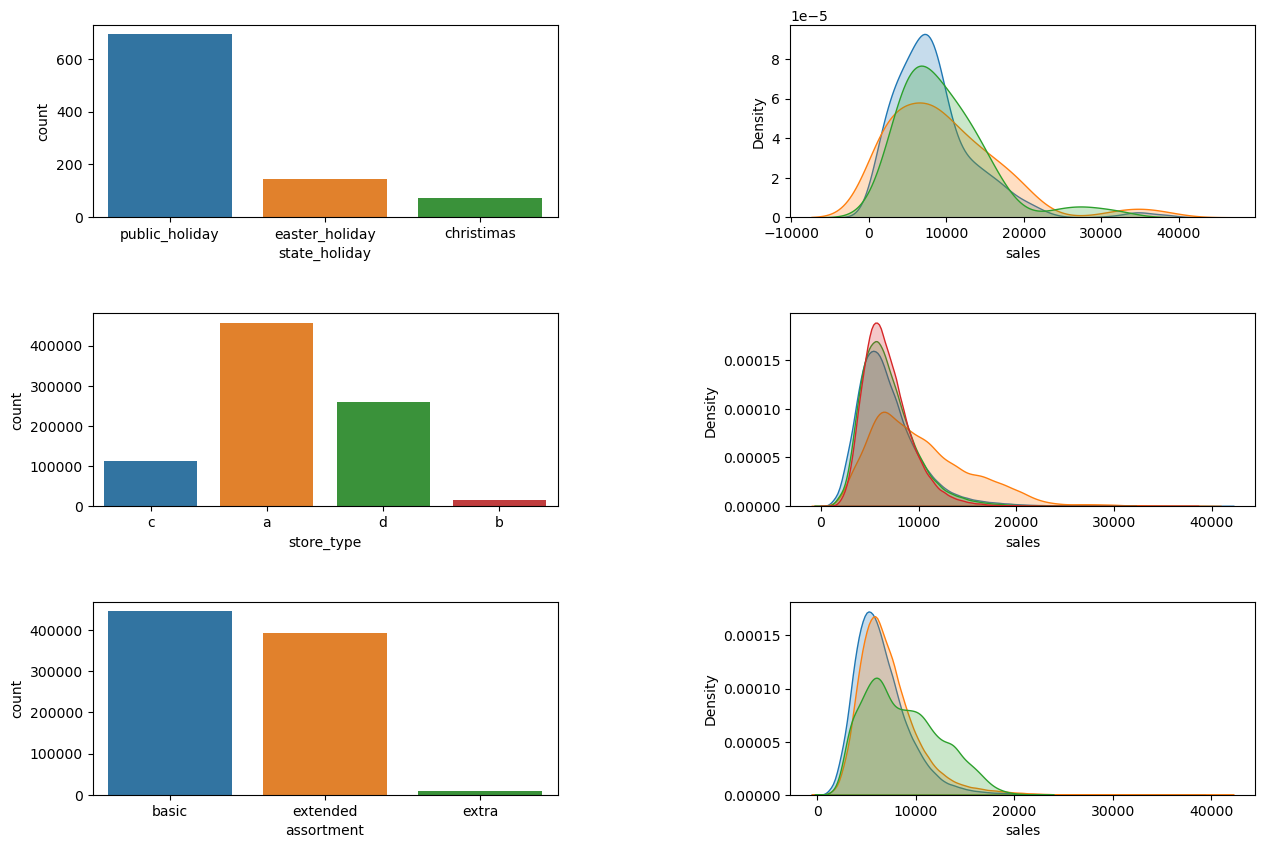

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# state_holiday
aux1 = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(x=aux1['state_holiday'], ax=axs[0, 0]);
sns.kdeplot(x=aux1[aux1['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, ax=axs[0, 1]);
sns.kdeplot(x=aux1[aux1['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True, ax=axs[0, 1]);
sns.kdeplot(x=aux1[aux1['state_holiday'] == 'christimas']['sales'], label='christimas', shade=True, ax=axs[0, 1]);


# store_type
sns.countplot(x=df4['store_type'], ax=axs[1, 0]);
sns.kdeplot(x=df4[df4['store_type'] == 'a']['sales'], label='a', shade=True, ax=axs[1, 1]);
sns.kdeplot(x=df4[df4['store_type'] == 'b']['sales'], label='b', shade=True, ax=axs[1, 1]);
sns.kdeplot(x=df4[df4['store_type'] == 'c']['sales'], label='c', shade=True, ax=axs[1, 1]);
sns.kdeplot(x=df4[df4['store_type'] == 'd']['sales'], label='d', shade=True, ax=axs[1, 1]);


# assorment
sns.countplot(x=df4['assortment'], ax=axs[2, 0]);
sns.kdeplot(x=df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True, ax=axs[2, 1]);
sns.kdeplot(x=df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True, ax=axs[2, 1]);
sns.kdeplot(x=df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True, ax=axs[2, 1]);


fig.subplots_adjust(wspace=0.5, hspace=0.5)

## 4.2. Análise Bivariada

#### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

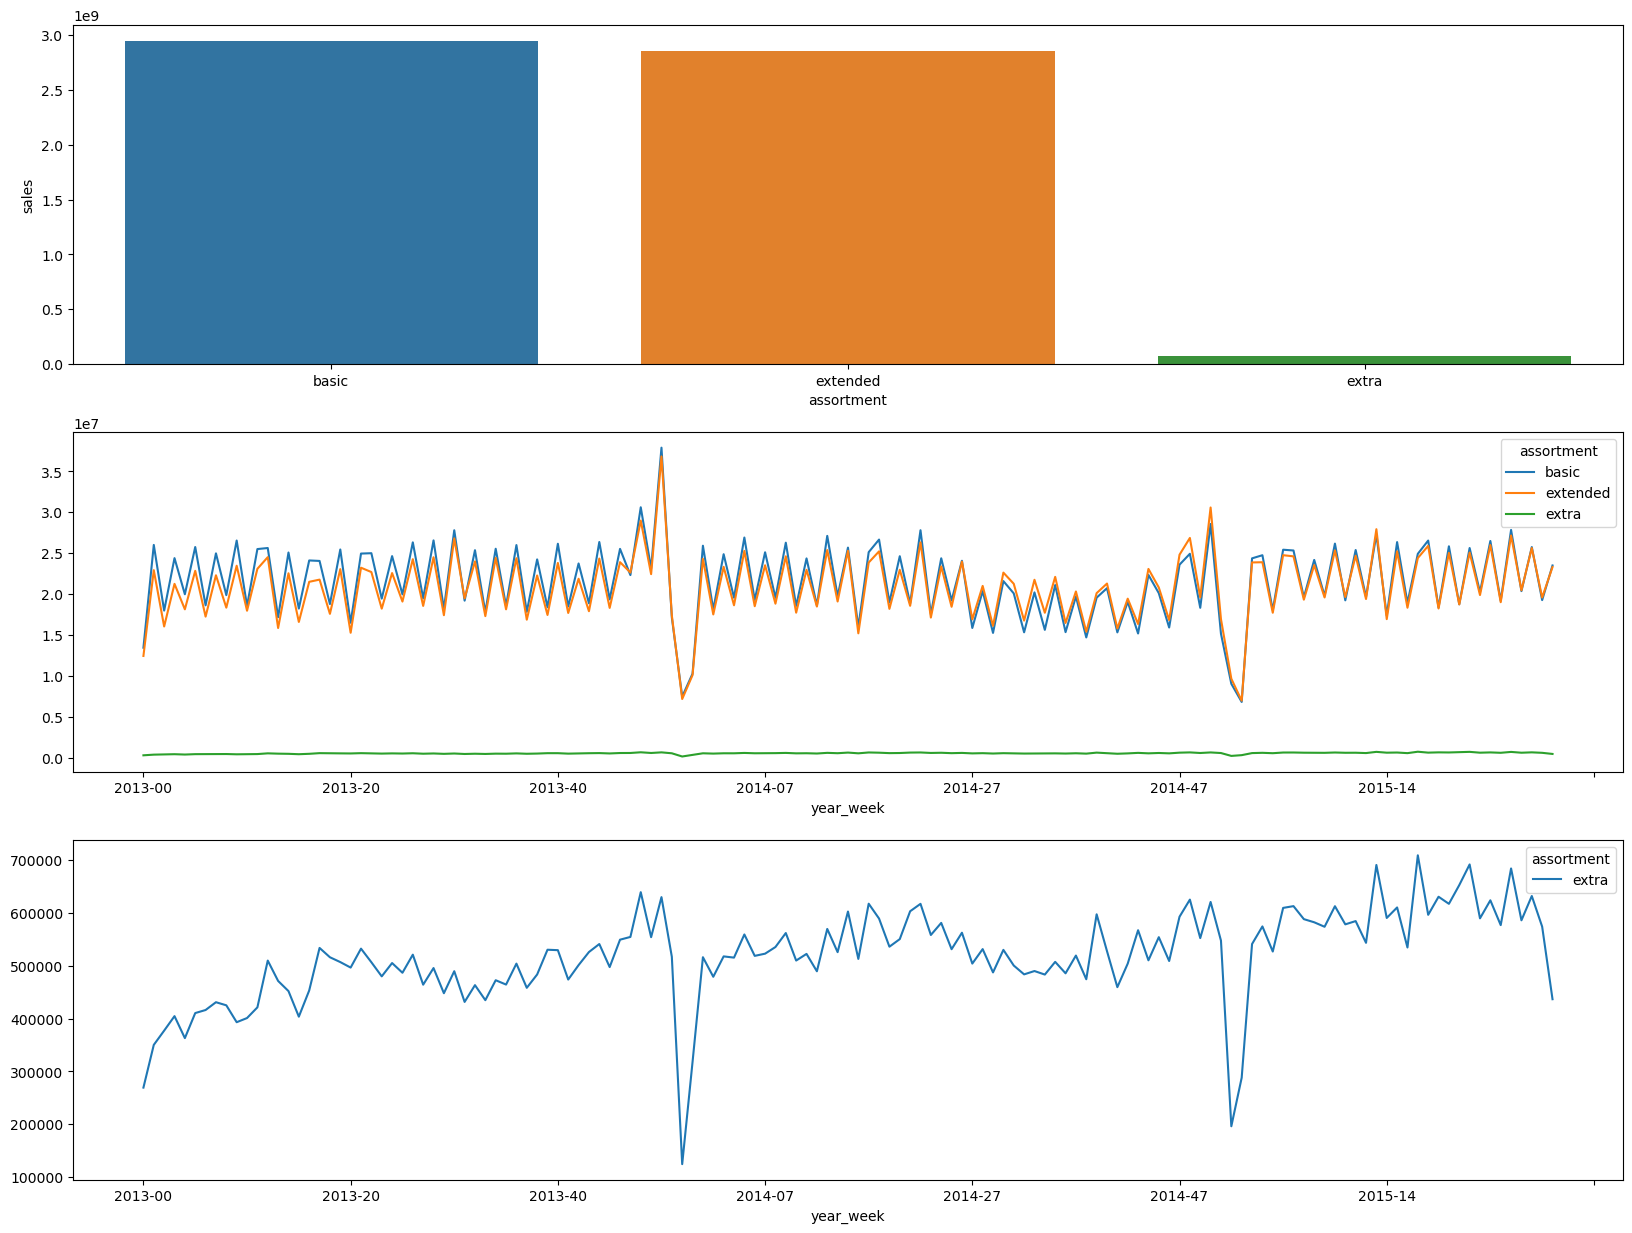

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, ax=axs[0]);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(ax=axs[1]);

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(ax=axs[2]);

#### H2. Lojas com compeditores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

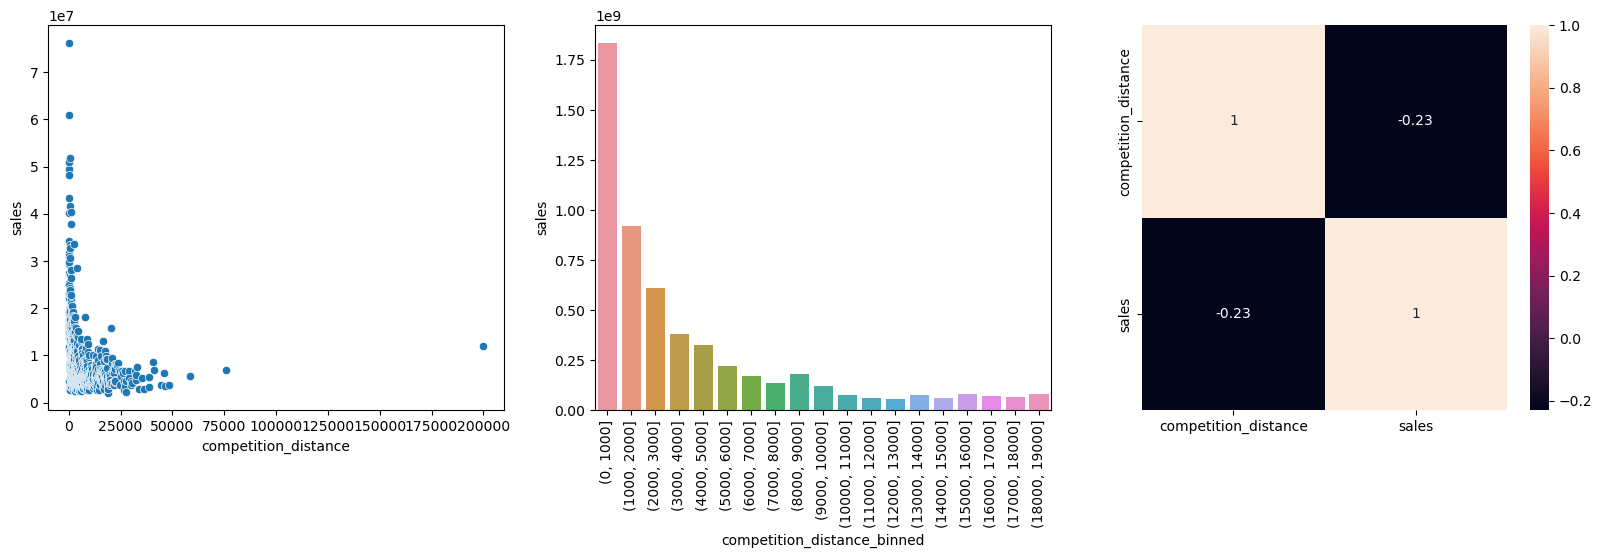

In [26]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.scatterplot(x='competition_distance', y='sales', data=aux1, ax=axs[0]);

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90);

sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True);

#### H3. Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS.

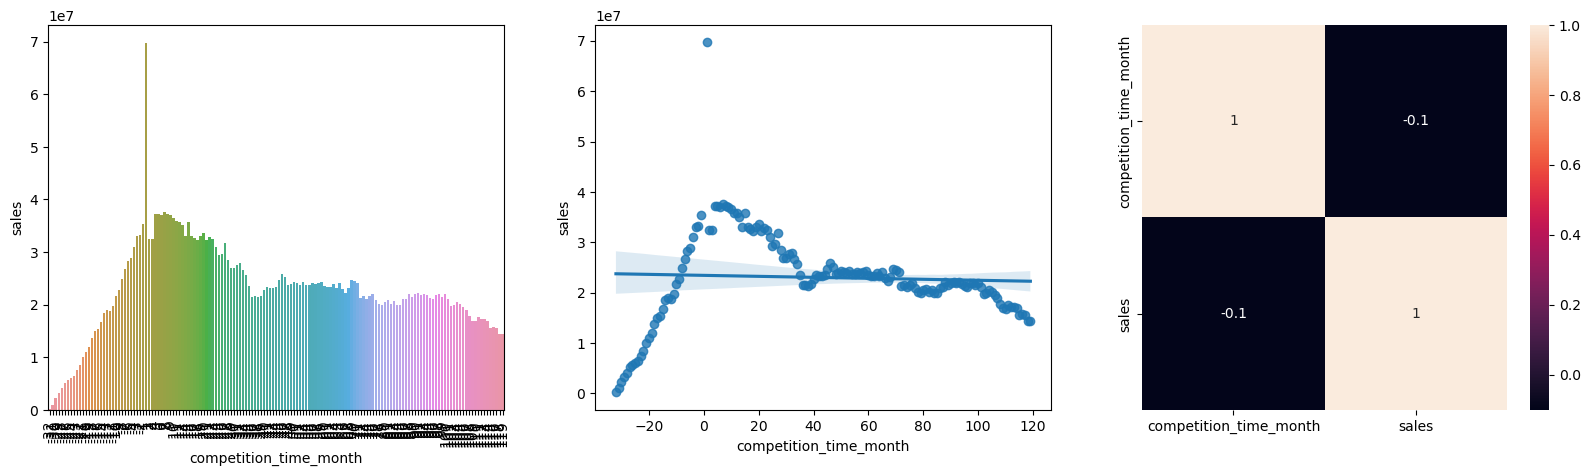

In [27]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# utilizando uma parcela dos dados na análise
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(x='competition_time_month', y='sales', data=aux2, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90);

sns.regplot(x='competition_time_month', y='sales', data=aux2, ax=axs[1]);

sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=axs[2]);

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos após um certo período de tempo de promoção.

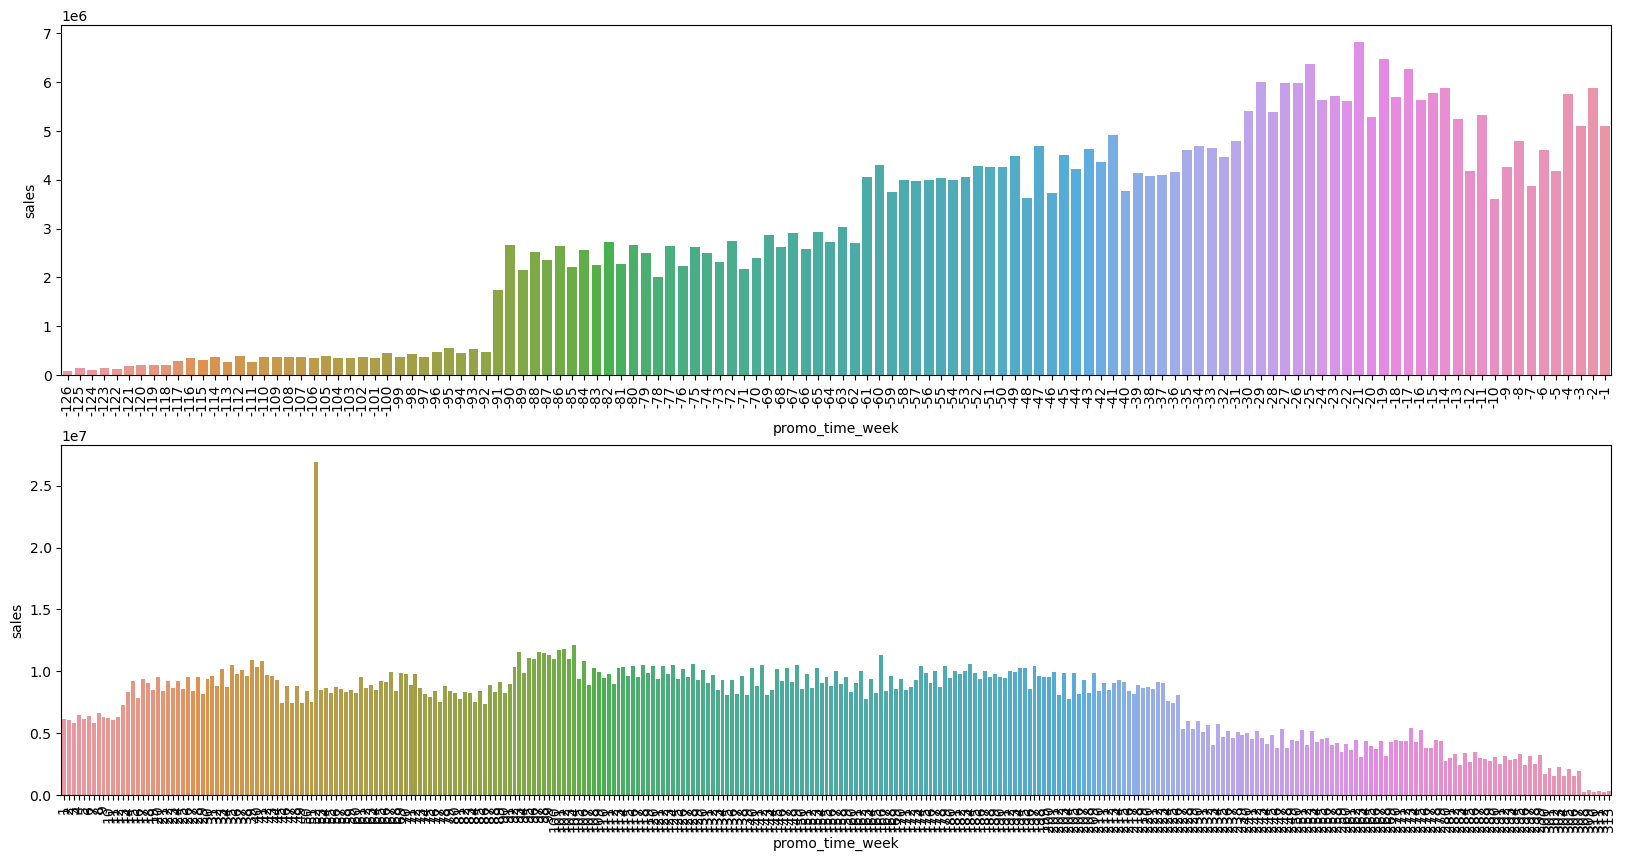

In [28]:
# devido a grande dispersão dos dados dividiremos os dados em 2 tempos
aux1 = df4[df4['promo_time_week'] < 0][['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index() # promo regular
aux2 = df4[df4['promo_time_week'] > 0][['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index() # promo extendido

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

sns.barplot(x='promo_time_week', y='sales', data=aux1, ax=axs[0]); 
sns.barplot(x='promo_time_week', y='sales', data=aux2, ax=axs[1]); 

# rotacionando os rótulos do eixo x
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.show();

#### H5. <s>Lojas mais dias de promoção deveriam vender mais.</s>
A validação dessa hipótese ficará para um segundo ciclo do CRISP.

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

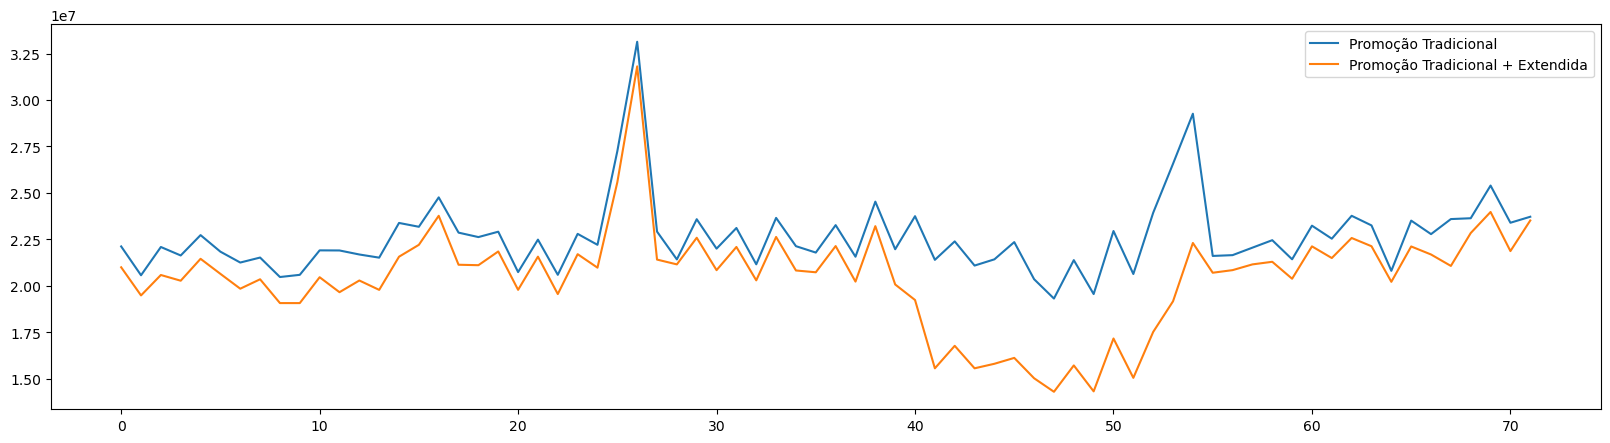

In [29]:
# promoção tradicional
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# promoção tradicional + extendida
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

aux1.plot(ax=axs);
aux2.plot(ax=axs);

axs.legend(labels=['Promoção Tradicional', 'Promoção Tradicional + Extendida']);

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertar durante o fetiado do Natal vendem menos.

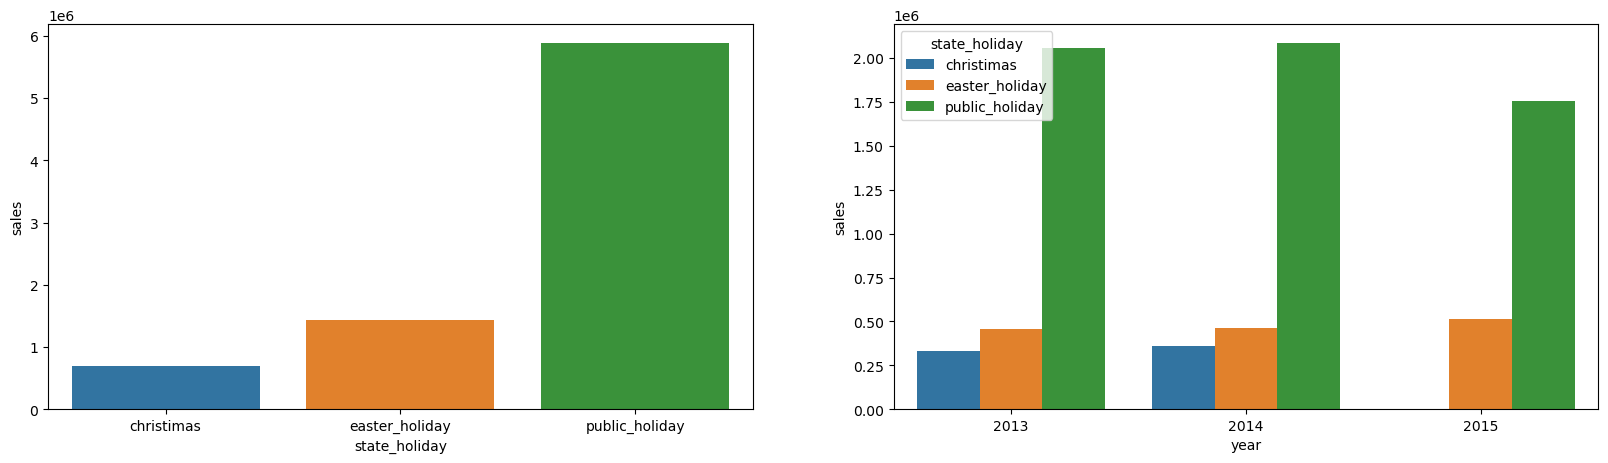

In [30]:
aux = df4[df4['state_holiday'] != 'regular_day']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axs[0]);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axs[1] );

#### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** As lojas estão vendendo menos ao longo dos anos.

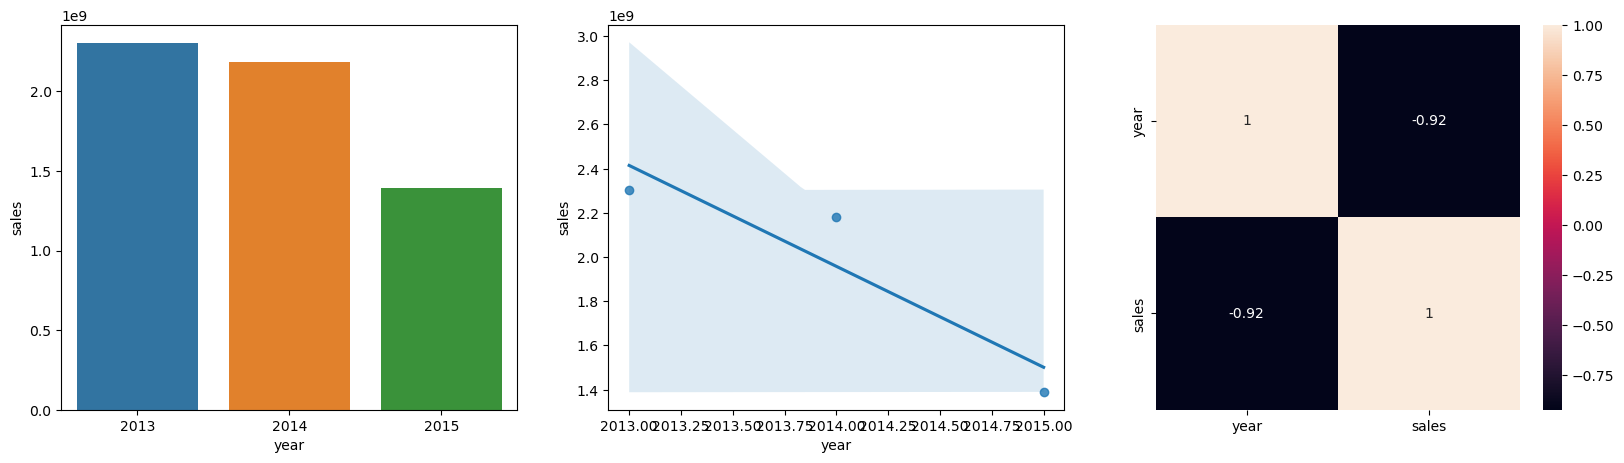

In [31]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(x='year', y='sales', data=aux1, ax=axs[0]);

sns.regplot(x='year', y='sales', data=aux1, ax=axs[1]);

sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=axs[2]);

#### H9. Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** As lojas vendem mais no segundo semestre do ano.

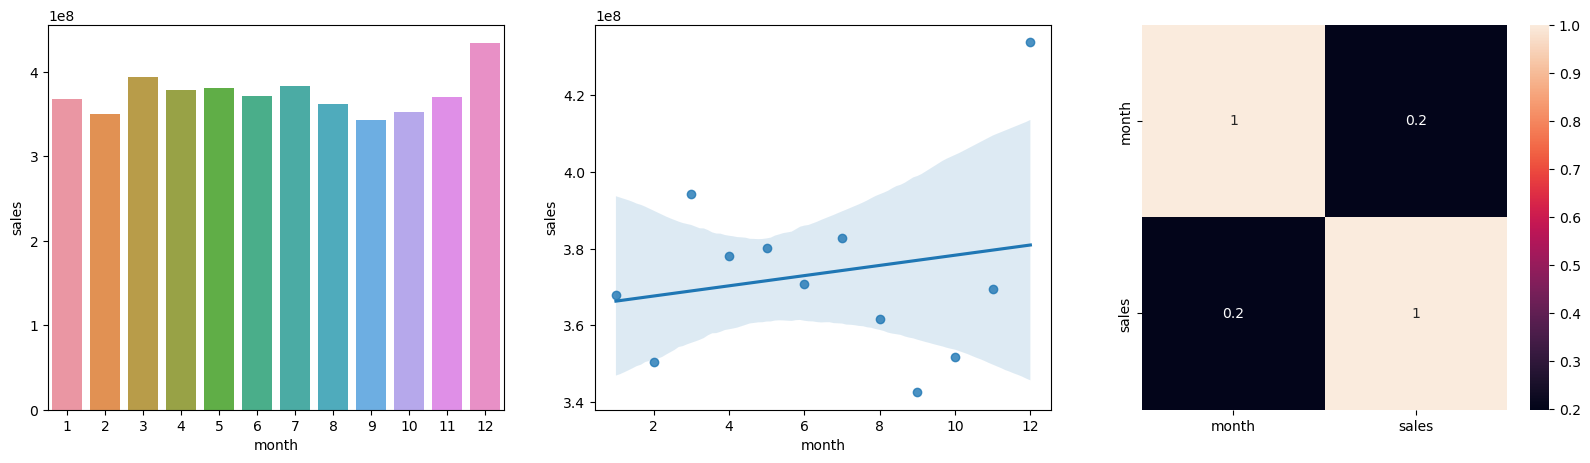

In [32]:
# removendo o ano de 2015 por não estar completo
aux1 = df4[['month', 'sales']][df4['year'] != 2015].groupby('month').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(x='month', y='sales', data=aux1, ax=axs[0]);

sns.regplot(x='month', y='sales', data=aux1, ax=axs[1]);

sns.heatmap(aux1.corr( method='pearson' ), annot=True, ax=axs[2]);

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSA** Observamos uma queda nas vendas conforme o passar o mês.

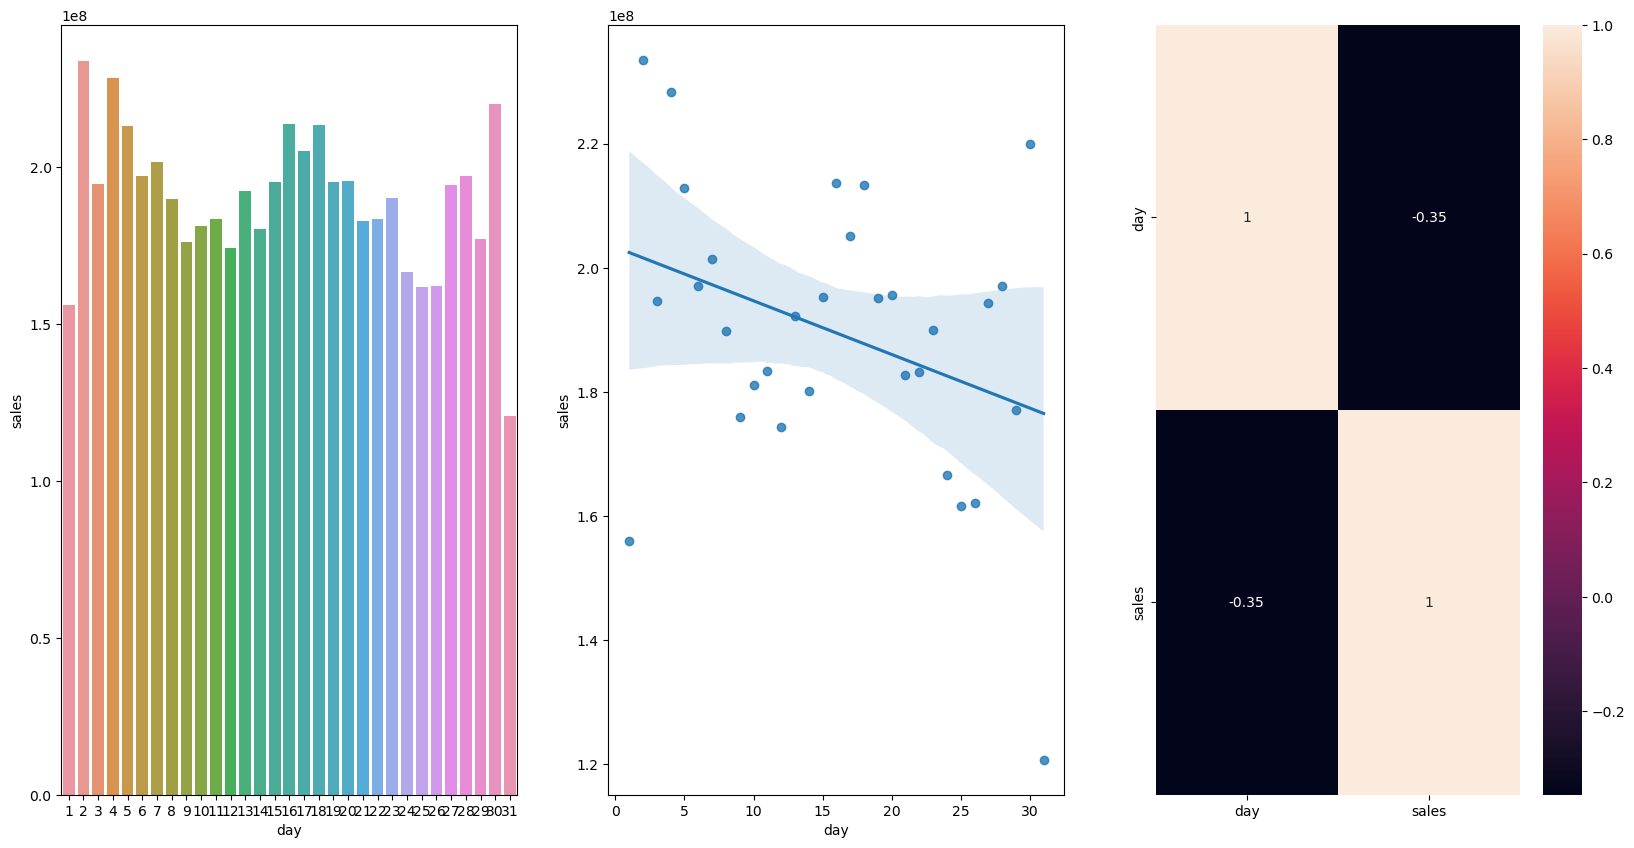

In [33]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

sns.barplot(x='day', y='sales', data=aux1, ax=axs[0]);

sns.regplot(x='day', y='sales', data=aux1, ax=axs[1]);

sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=axs[2]);

#### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos aos finais de semana.

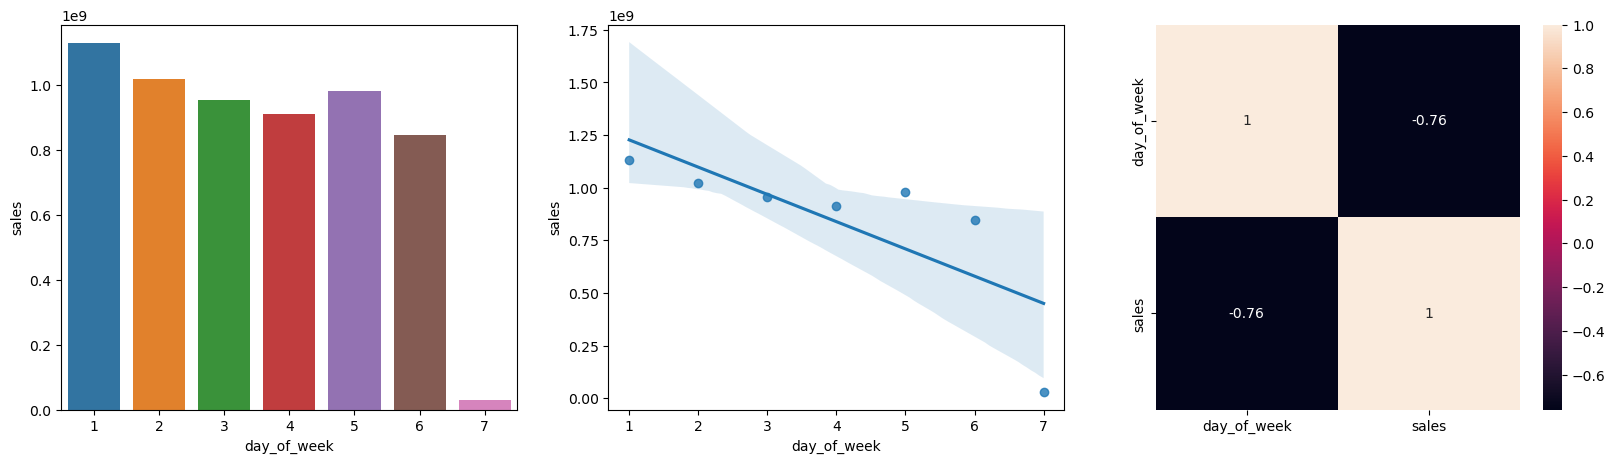

In [34]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(x='day_of_week', y='sales', data=aux1, ax=axs[0]);

sns.regplot(x='day_of_week', y='sales', data=aux1, ax=axs[1]);

sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=axs[2]);

#### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, com exceção do mês de Agosto.

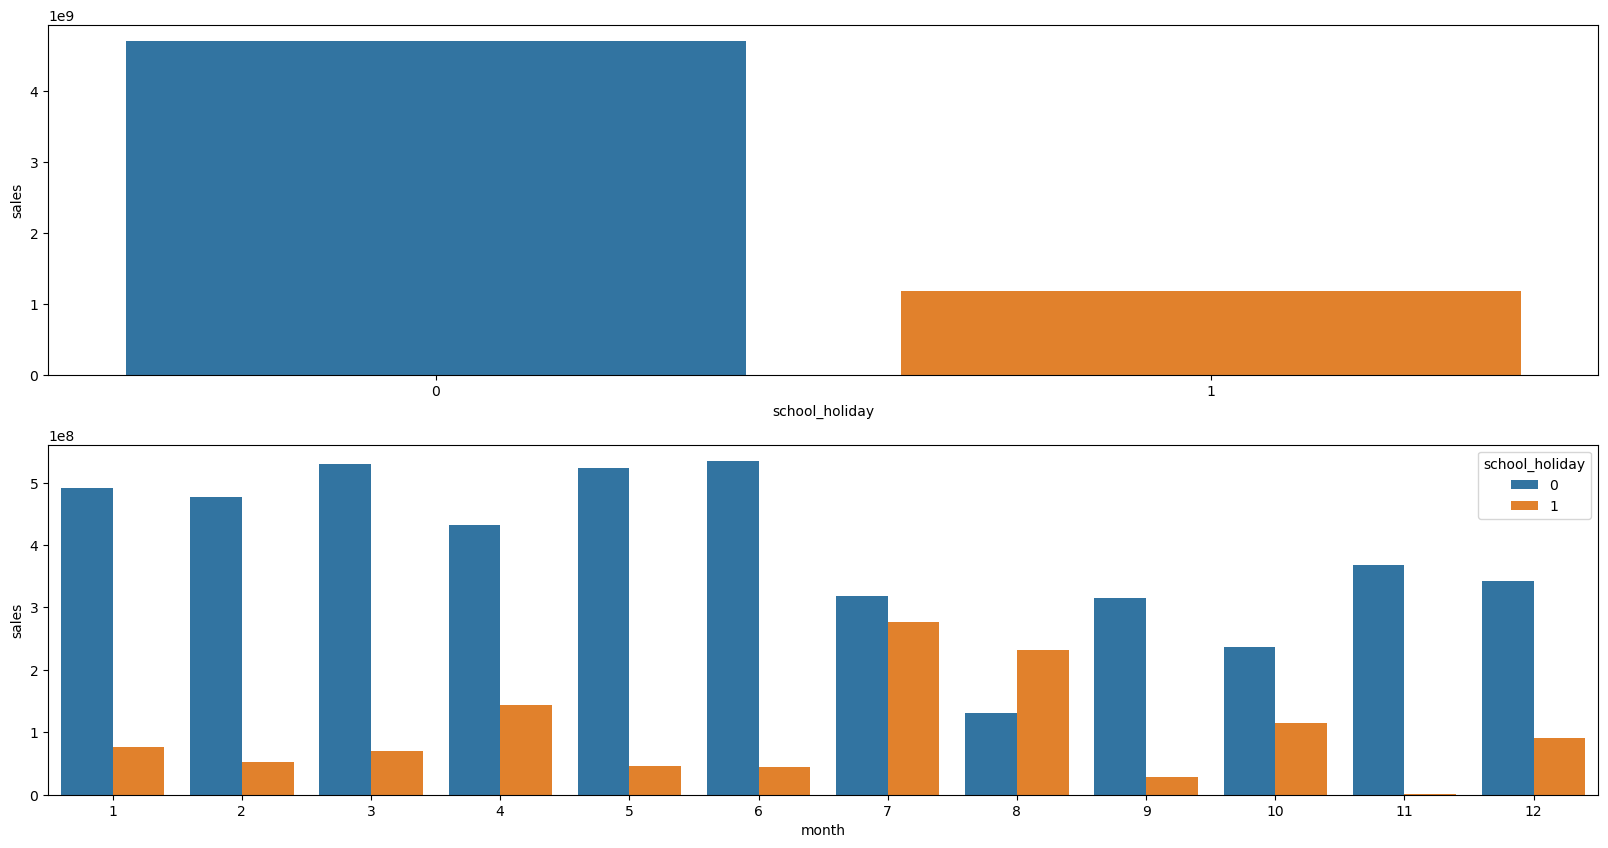

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1, ax=axs[0]);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2, ax=axs[1]);

#### Resumo das Hipóteses

In [36]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'], 
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'], 
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'], 
       ['H5', '-', '-'], 
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'], 
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Verdadeira', 'Alta'], 
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'], 
       ['H12', 'Verdadeira', 'Baixa']]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Atributos Numéricos

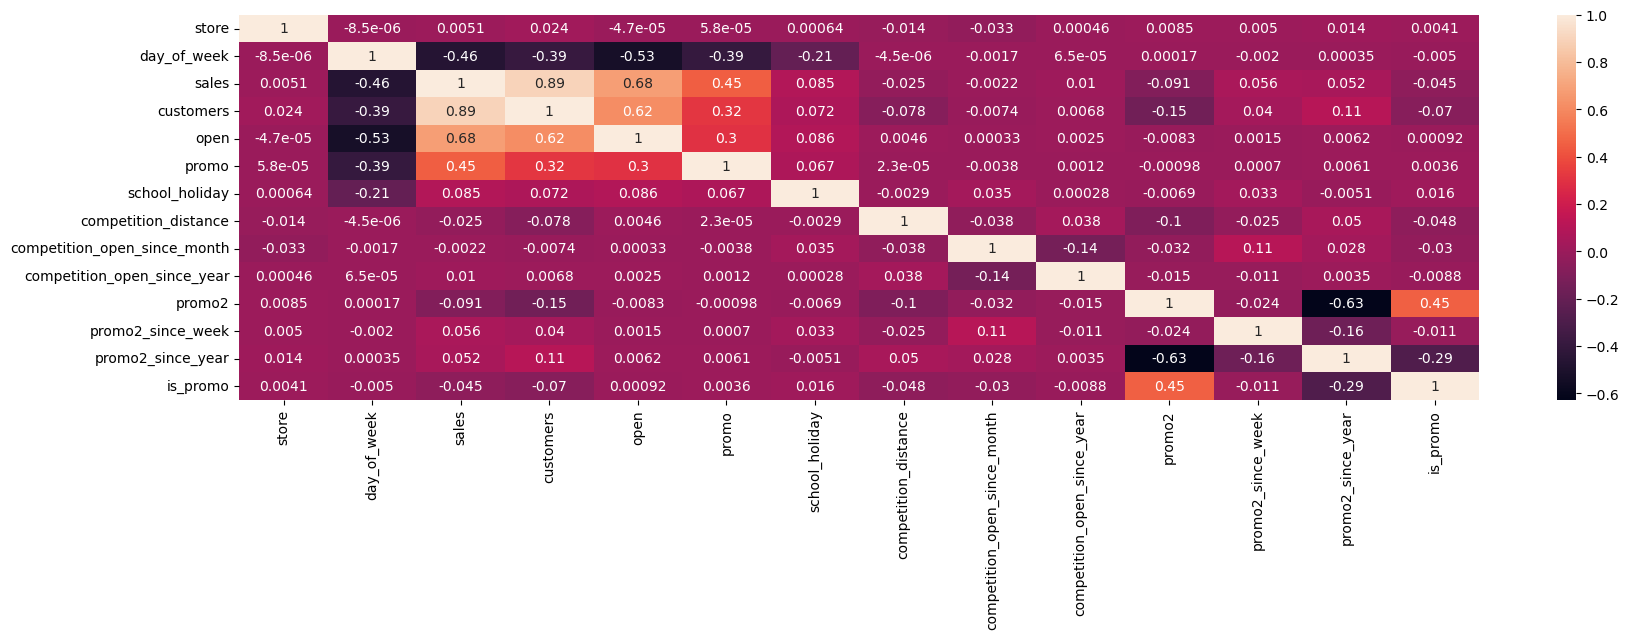

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

correlation = atributos_num.corr(method='pearson')

sns.heatmap(correlation, annot=True, ax=axs);

### 4.3.2. Atributos Categóricos

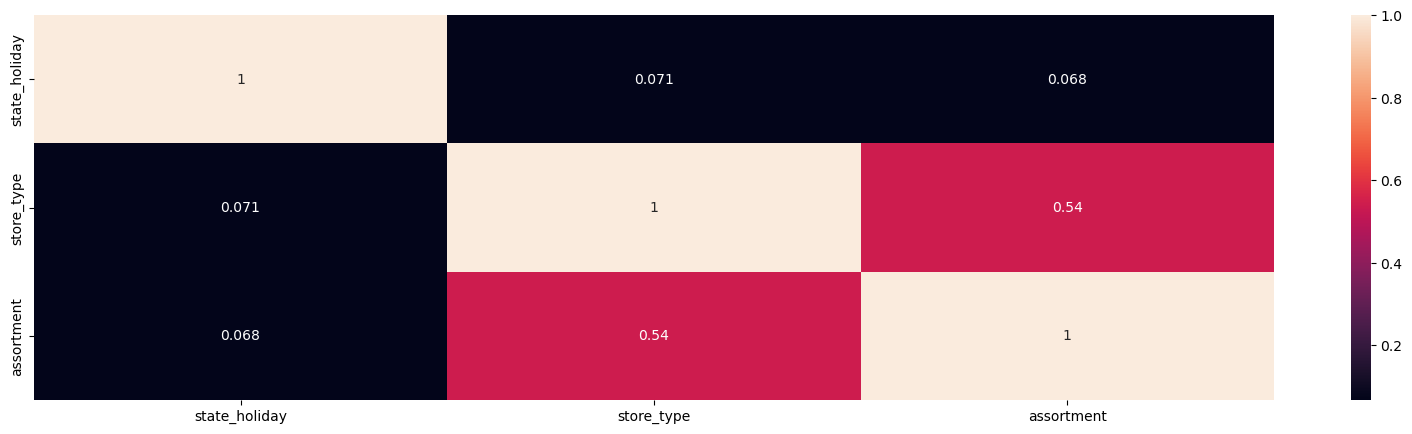

In [38]:
# dados categóricos
dc = df4.select_dtypes( include='object' )

# função de cramer V - utilizada na análise de correlação entre dados categóricos
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, (chi2/n) - (((k-1)*(r-1))/(n-1)))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / min(kcorr-1, rcorr-1))

# calcular cramer V
a1 = cramer_v(dc['state_holiday'], dc['state_holiday'])
a2 = cramer_v(dc['state_holiday'], dc['store_type'])
a3 = cramer_v(dc['state_holiday'], dc['assortment'])

a4 = cramer_v(dc['store_type'], dc['state_holiday'])
a5 = cramer_v(dc['store_type'], dc['store_type'])
a6 = cramer_v(dc['store_type'], dc['assortment'])

a7 = cramer_v(dc['assortment'], dc['state_holiday'])
a8 = cramer_v(dc['assortment'], dc['store_type'])
a9 = cramer_v(dc['assortment'], dc['assortment'])

# dataset final
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type'   : [a4, a5, a6],
                  'assortment'   : [a7, a8, a9]})

d = d.set_index(d.columns)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

sns.heatmap(d, annot=True, ax=axs);

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [39]:
df5 = df4.copy()

## 5.1. Normalização

Verificando o item '4.1.2. Variável Numérica' observamos que nenhuma variável tem uma distribuição normal. Por isso não realizaremos a normalização.

## 5.2. Reescalonamento / Redimensionamento

In [40]:
rs = RobustScaler()
mms = MinMaxScaler()

# variáveis não cíclicas

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

## 5.3. Transformação

### 5.3.1. Encoding

In [41]:
le = LabelEncoder()

# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
df5['store_type'] = le.fit_transform(df5['store_type']).astype('int64')
pickle.dump(le, open('parameter/store_type_encoding.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformação Variável Resposta

In [42]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Transformação - Natureza

In [43]:
# variáveis cíclicas

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# 6.0. PASSO 06 - SELECIONANDO AS FEATURES

In [44]:
df6 = df5.copy()

## 6.1. Divisão do DataFrame em Treinamento e Teste

In [45]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [46]:
# separando dados de teste - últimas 6 semanas antes do último dia 'date'
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [47]:
# dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Data Mínima de Treino: {}'.format(X_train['date'].min()))
print('Data Máxima de Treino: {}'.format(X_train['date'].max()))

print('\nData Mínima de Teste: {}'.format(X_test['date'].min()))
print('Data Máxima de Teste: {}'.format(X_test['date'].max()))

Data Mínima de Treino: 2013-01-01 00:00:00
Data Máxima de Treino: 2015-06-18 00:00:00

Data Mínima de Teste: 2015-06-19 00:00:00
Data Máxima de Teste: 2015-07-31 00:00:00


## 6.2. Selecionando Features com Boruta

In [48]:
# # dataset de treino e test pro boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # definindo o tipo de algoritmo - Random Forest Regressor
# rf = RandomForestRegressor(n_jobs=-1)

# # definindo Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Melhores Features do Boruta

In [49]:
# cols_selected = boruta.support_.tolist()

# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [50]:
# print('Colunas selecionadas: {}'.format(cols_selected_boruta))
# print('\n')
# print('Colunas não selecionadas: {}'.format(cols_not_selected_boruta))

## 6.3. Seleção Manual das Features

In [51]:
# features selecionadas pelo boruta + algumas relacionadas
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 
                        'competition_time_month', 'promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                        'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

# features retiradas para a análise
feat_to_add = ['date', 'sales']

# features finais
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. PASSO 07 - MODELAGEM DO MACHINE LEARNING

In [52]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

# cross_validation(x_training, kfold, model_name, model, verbose=False):

## 7.1. Modelo da Média

In [53]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predição
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Nome do modelo,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [54]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# predição
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Nome do modelo,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [55]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [56]:
# modelo
lrr = Lasso(alpha=0.001).fit(x_train, y_train)

# predição
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso Model', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Nome do modelo,MAE,MAPE,RMSE
0,Lasso Model,1869.571858,0.288111,2694.005137


### 7.3.1. Linear Regression Regularized Model (Lasso) - Cross Validation

In [57]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Lasso,2088.88+/-327.01,0.3+/-0.01,2988.6+/-499.57


## 7.4. Random Forest Regressor

In [58]:
# modelo
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,
                           random_state=42).fit(x_train, y_train)

# predição
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Nome do modelo,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837


### 7.4.1. Random Forest Regressor - Cross Validation

In [59]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


Número KFold: 5

Número KFold: 4

Número KFold: 3

Número KFold: 2

Número KFold: 1


,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.97+/-218.4,0.12+/-0.02,1256.45+/-318.73


## 7.5. XGBoost Regressor

In [60]:
import xgboost as xgb

# modelo
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# predição
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Nome do modelo,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.276451,0.949412,7330.624439


### 7.5.1. XGBoost Regressor - Cross Validation

In [61]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


Número KFold: 5

Número KFold: 4

Número KFold: 3

Número KFold: 2

Número KFold: 1


,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.26+/-588.69,0.95+/-0.0,7715.27+/-689.53


## 7.6. Performance

In [62]:
# Performance sem cross validation
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Nome do modelo,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso Model,1869.571858,0.288111,2694.005137
0,XGBoost Regressor,6683.276451,0.949412,7330.624439


In [63]:
# Performance com cross validation
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.97+/-218.4,0.12+/-0.02,1256.45+/-318.73
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2088.88+/-327.01,0.3+/-0.01,2988.6+/-499.57
0,XGBoost Regressor,7049.26+/-588.69,0.95+/-0.0,7715.27+/-689.53


# 8.0. PASSO 08 - AJUSTES FINOS DOS HIPERPARÂMETROS

## 8.1. Random Search

In [64]:
# param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#          'eta': [0.01, 0.03],
#          'max_depth': [3, 5, 9],
#          'subsample': [0.1, 0.5, 0.7],
#          'colsample_bytree': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 8, 15]}

# MAX_EVAL = 5

In [65]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # escolha de parâmetros randomicamente
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
    
#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])
    
#     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result    

## 8.2. Modelo Final

In [66]:
param_tuned = {'n_estimators': 3000,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytree': 0.3,
               'min_child_weight': 3}

In [67]:
# modelo
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# predição
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Nome do modelo,MAE,MAPE,RMSE
0,XGBoost Regressor,683.941775,0.098911,995.614786


In [68]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.006831393008778689

In [69]:
# salvando o modelo treinado
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb') )

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [70]:
df9 = X_test[cols_selected_boruta_full]

# re-escala
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Desempenho dos Negócios

In [89]:
# soma das predições
df91 = df9[['store', 'sales', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
               lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
               lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# alterando a ordem das colunas
df92 = df92[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df92.sort_values('MAPE', ascending=False).head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,137966.0,105092.859375,101835.942344,108349.776406,3256.917031,0.548119
908,909,360069.0,240724.921875,232962.907927,248486.935823,7762.013948,0.536395
875,876,257556.0,203103.187500,199156.817765,207049.557235,3946.369735,0.303828
594,595,529213.0,371111.500000,366838.486143,375384.513857,4273.013857,0.295367
901,902,147908.0,182988.437500,182040.317568,183936.557432,948.119932,0.236028


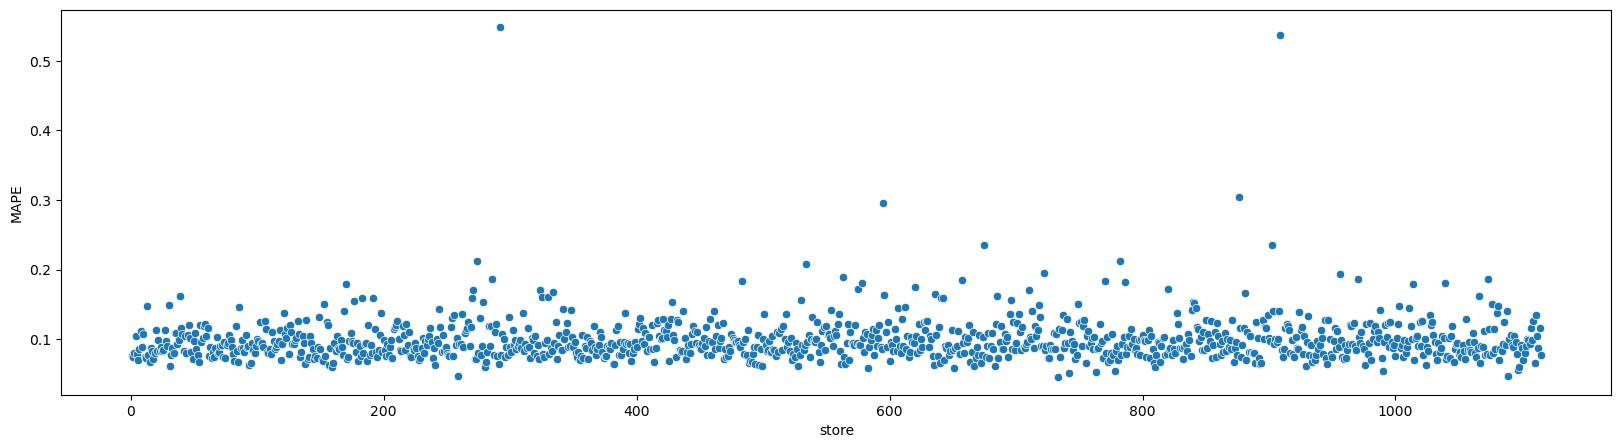

In [72]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Desempenho Total

In [73]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(
            lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:.2f}'.format)
df93

,Scenarios,Values
0,predictions,R$ 282184064.00
1,worst_scenario,R$ 281417670.62
2,best_scenario,R$ 282950489.49


## 9.3. Performance do Modelo

In [74]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

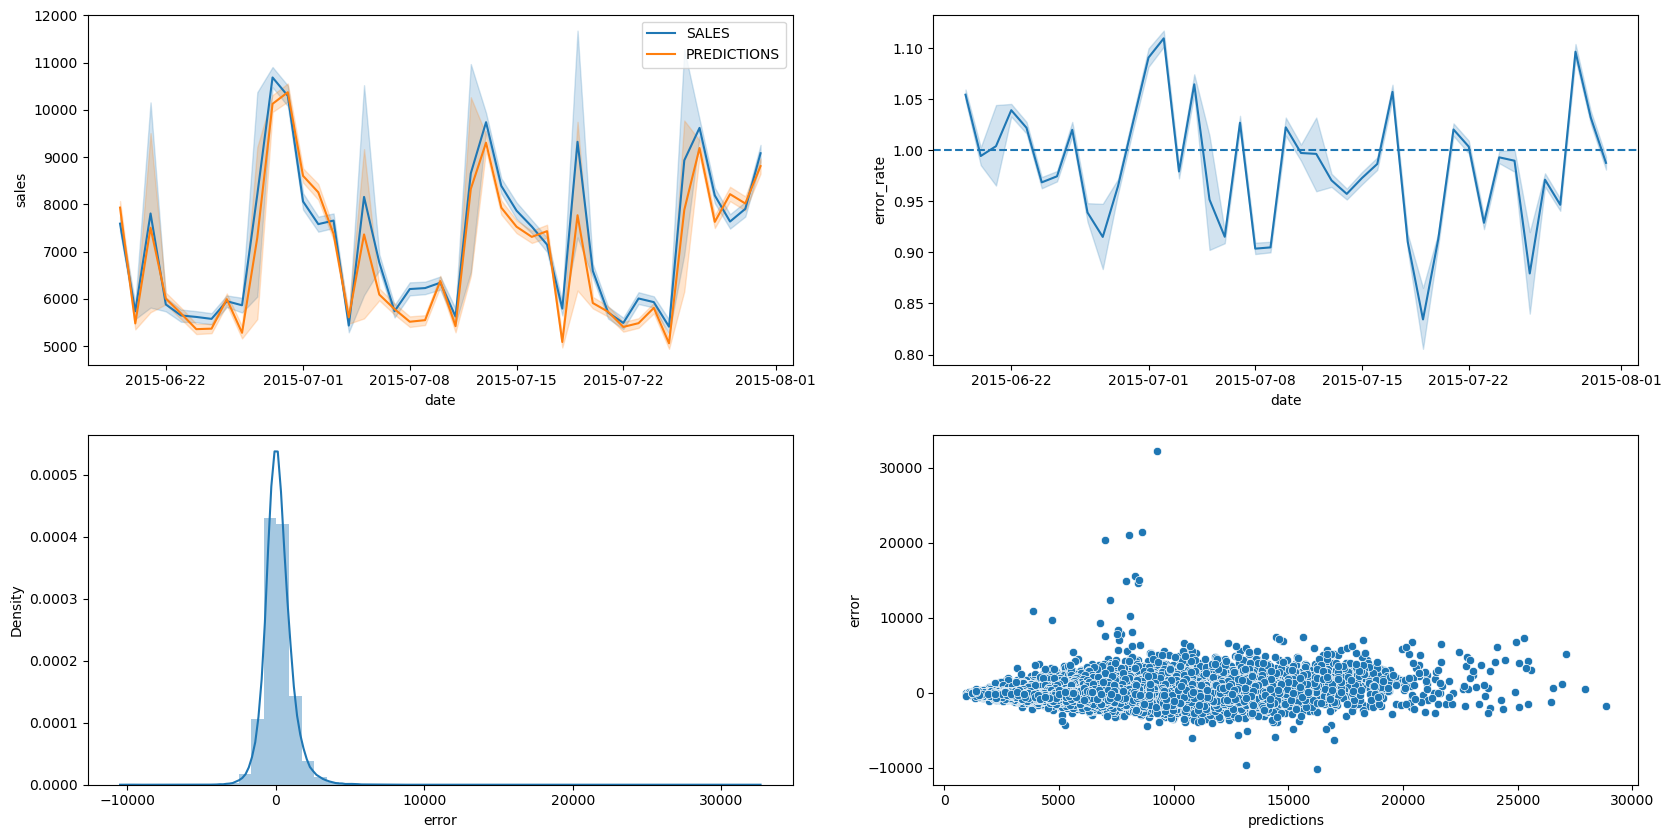

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.lineplot(x='date', y='sales', data=df9, label='SALES', ax=axs[0, 0]);
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS', ax=axs[0, 0]);

sns.lineplot(x='date', y='error_rate', data=df9, ax=axs[0, 1]);
axs[0, 1].axhline(1, linestyle='--');

sns.distplot(df9['error'], ax=axs[1, 0]);

sns.scatterplot(x=df9['predictions'], y= df9['error'], ax=axs[1, 1]);

# 10.0. PASSO 10 - IMPLANTANDO MODELO EM PRODUÇÃO

## 10.1. Classe Rossmann

In [76]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossman(object):
    def __init__(self):
        self.home_path = 'C:/Users/aline/Comunidade DS/DS em Producao/'
        self.competition_distance_scaler = pickle.load( 
            open(self.home_path + 
                 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(
            open(self.home_path + 
                 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load( 
            open(self.home_path + 
                 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load( 
            open(self.home_path + 
                 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding = pickle.load( 
            open(self.home_path + 
                 'parameter/store_type_encoding.pkl', 'rb'))

    def data_cleaning(self, df1):        
        ### 1.1. Renomeando as colunas
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 
                    'Assortment','CompetitionDistance',
                    'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2',
                    'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # renomeando
        df1.columns = cols_new

        ### 1.3. Tipo de dados
        df1['date'] = pd.to_datetime(df1['date'])

        ### 1.5. Preenchendo os NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if 
                                          math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( 
            lambda x: x['date'].month if math.isnan( 
                      x['competition_open_since_month'] ) else 
                      x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( 
            lambda x: x['date'].year if math.isnan( 
                      x['competition_open_since_year'] ) else 
                      x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( 
            lambda x: x['date'].week if math.isnan( 
                      x['promo2_since_week'] ) else 
                      x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply( 
            lambda x: x['date'].year if math.isnan( 
                      x['promo2_since_year'] ) else 
                      x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
                     6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct',
                     11: 'Nov', 12: 'Dec' }

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( 
            lambda x: 0 if x['promo_interval'] == 0 else 1 if 
            x['month_map'] in x['promo_interval'].split(',') else 0, 
            axis=1 )

        ### 1.6. Alterando os tipos de dados
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
            year=x['competition_open_since_year'], 
            month=x['competition_open_since_month'], day=1), axis=1)

        df2['competition_time_month'] = (( 
            df2['date'] - df2['competition_since'])/30).apply( 
            lambda x: x.days ).astype('int64')

        # promo since
        df2['promo_since'] = ( df2['promo2_since_year'].astype( str ) 
                               + '-' + 
                               df2['promo2_since_week'].astype( str ) )

        df2['promo_since'] = df2['promo_since'].apply( 
            lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - 
                      datetime.timedelta( days=7 ) )

        df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 
                                 ).apply( lambda x: x.days
                                        ).astype('int64')

        # assortment
        df2['assortment'] = df2['assortment'].apply( 
            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 
                      'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(
            lambda x: 'public_holiday' if x == 'a' else 
                      'easter_holiday' if x == 'b' else 
                      'christmas' if x == 'c' else 'regular_day' )

        ## 3.0. PASSO 03 - FILTRAGEM DAS VARIÁVEIS
        ### 3.1. Filtragem de Variáveis
        df2 = df2[(df2['open'] != 0)]

        #### 3.1.2. Filtragem das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparation(self, df5):
        ## 5.2.Reescalonamento / Redimensionamento
        df5['competition_distance'] = self.competition_distance_scaler.transform( 
            df5[['competition_distance']].values)

        #### competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( 
            df5[['competition_time_month']].values )
        
        #### promo time week
        df5['promo_time_week'] =         self.promo_time_week_scaler.transform( 
            df5[['promo_time_week']].values )
                
        #### year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        ### 5.3.1. Encoding
        # state_holiday - Utilizando o One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=
                              ['state_holiday'] )

        # store_type - Utilizando o Label Encoding
        df5['store_type'] = self.store_type_encoding.transform( 
            df5['store_type'] )

        # assortment - Utilizando o Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Transformação
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( 
            lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( 
            lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( 
            lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( 
            lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( 
            lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( 
            lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( 
            lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( 
            lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        cols_selected = [ 
            'store', 'promo', 'store_type', 'assortment', 
            'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week',
            'promo2_since_year', 'competition_time_month',
            'promo_time_week', 'month_sin', 'month_cos', 'day_sin', 
            'day_cos', 'week_of_year_sin', 'week_of_year_cos',
            'day_of_week_sin', 'day_of_week_cos' ]
                
        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data ):
        # preditor
        pred = model.predict( test_data )
                
        original_data['predictions'] = np.expm1( pred )
        
        return original_data.to_json(orient='records', data_format='iso')

## 10.2. API Handler

In [77]:
import pandas as pd
import pickle

from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# carregando modelo
model = pickle.load(open('C:/Users/aline/Comunidade DS/DS em Producao/model/model_rossmann.pkl', 'rb') )

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST']) 

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # se houver dados
        if isinstance(test_json, dict): # exemplo único
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # múltiplo exemplos
            test_raw = pd.DataFrame(test_json, 
                                    columns=test_json[0].keys())
        
        # instanciando a classe Rossmann
        pipeline = Rossmann()
        
        # limpando os dados
        df1 = pipeline.data_cleaning(test_raw)
        
        # construindo as features
        df2 = pipeline.feature_engineering(df1)
        
        # prepatando os dados
        df3 = pipeline.data_preparation(df2)
        
        # realizando a predição
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0') # rodar no localhost (minha máquina)

ModuleNotFoundError: No module named 'rossmann'

## 10.3. Testando a API 

In [78]:
# loading test dataset
df10 = pd.read_csv( 'C:/Users/aline/Comunidade DS/DS em Producao/data/test.csv' )

In [84]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 35, 27, 12])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [85]:
# O Json é utilizado para o envio de informação pela API, por isso é necessário converter o DataFrame para Json antes de enviar.
# convert DF to Json
data = json.dumps( df_test.to_dict( orient='records') )

In [86]:
# API Call
url = 'https://teste-rossmann-api-lg8r.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [87]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [88]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print( 'Store Number {} will sell {:,.2f} in the next 6 weeks'.format(   
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Store Number 12 will sell 311,577.85 in the next 6 weeks
Store Number 24 will sell 381,781.53 in the next 6 weeks
Store Number 27 will sell 390,499.92 in the next 6 weeks
Store Number 35 will sell 429,119.80 in the next 6 weeks
